# MEFE - TP computacional 1

#### Tomás Di Napoli

Este trabajo es la resolución del primer TP computacional de [MEFE](http://materias.df.uba.ar/meefea2023c1/), cuya consigna se puede ver [acá](http://materias.df.uba.ar/meefea2023c1/files/2023/04/Computacional1_MEFE2023.pdf). También tiene su versión en [Jupyter Notebook](https://colab.research.google.com/drive/1cy--G69O031nhcRVmJvtWlc4_ZoPo5qQ?usp=sharing) junto con otros ejercicios de la materia que estoy subiendo a [este](https://github.com/tdinapoli/mefe/) repositorio de github.

**1)**
Primero importo las librerías que voy a necesitar y defino algunos parámetros útiles para graficar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binom, hypergeom, poisson
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

Defino una función ```bernoulli```, que toma ```n``` la cantidad de veces que "tiramos una moneda" y ```p``` la probabilidad de que salga cara (que lo represento con un 1). Opcionalmente toma ```size``` para que el resultado sea un array de experimentos de Bernoulli de la forma que yo quiera.

Luego implemento la función ```contar_exitos``` que toma un conjunto de experimentos de Bernoulli y cuenta la cantidad de caras (1's). Luego llamo a las funciones y comparo con los valores de p y (1-p).

In [2]:
def bernoulli(n, p, size=None):
    if not size:
        return (np.random.random(size=n) < p)*1
    else:
        return (np.random.random(size=size) < p) * 1

def contar_exitos(experimentos, axis=0):
    return np.sum(experimentos, axis=axis)

n = 1000000
p = 0.02
experimentos = bernoulli(n, p)
exitos = contar_exitos(experimentos)
fracasos = n - exitos 
print(f"p \tes \t{p}")
print(f"1-p \tes \t{1-p}")
print(f"en {n} experimentos,")
print(f"p(exito) \t= \t{exitos/n}")
print(f"p(fracaso) \t= \t{fracasos/n}") 

p 	es 	0.02
1-p 	es 	0.98
en 1000000 experimentos,
p(exito) 	= 	0.019928
p(fracaso) 	= 	0.980072


**2)**
Uso las funciones ```bernoulli``` y ```contar_exitos``` para simular que llegan 15 fotones a un detector con eficiencia del 75%. Esto lo puedo hacer porque la llegada de cada fotón al detector es como tirar una moneda: o es detectado, o no lo es.

In [3]:
eficiencia = 0.75
fotones = 15
repeticiones = 1000
detecciones = bernoulli(fotones, eficiencia, size=(repeticiones, fotones))
experimentos = contar_exitos(detecciones, axis=1)

Ahora ```experimentos``` es una lista con la cantidad de fotones que fueron detectados en cada experimento.

Como dije antes la detección de cada fotón es binaria, y además, la detección de cada fotón es independiente del resto de detecciones. Por lo tanto, la distribución asociada a la detección de fotones es la binomial

$$B(k \mid n, p) = {n \choose k} p^k (1-p)^{n-k},$$

donde en este caso $n=15$ y $p=0.75$.

Entonces, grafico el histograma de los experimentos y comparo con la binomial. Para comparar uso la función ```binom``` de ```scipy.stats```, que me permite inicializar una variable aleatoria ```rv``` binomial. ```rv.pmf(k)``` evalúa a la binomial en ```k```.

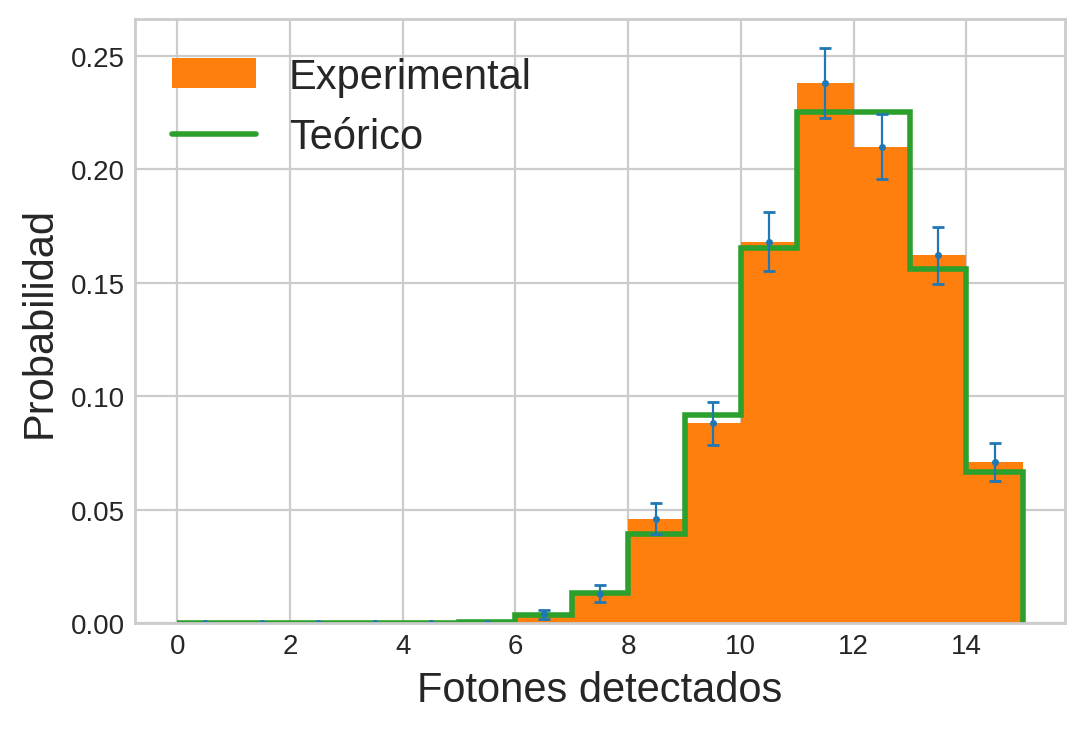

In [4]:
# Genero la rv y la evalúo en todos los k posibles, de 0
# a 15 para graficar el histograma teórico.
rv = binom(fotones, eficiencia)
freq_teo = np.array([rv.pmf(x) for x in range(fotones)])

# Creo el histograma con los datos generados
freq, bin_edges = np.histogram(experimentos,
                             bins=range(fotones+1),
                             density=True)
# Grafico los errores
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width/2
barras_error = np.sqrt(freq)/np.sqrt(len(experimentos))

plt.errorbar(bin_centers, freq, yerr=barras_error,
             fmt='.', markersize=3, linewidth=0.8, capsize=2)
# Grafico
plt.stairs(freq, bin_edges, fill=True, label="Experimental")
plt.stairs(freq_teo, bin_edges, linewidth=2,label="Teórico")
plt.ylabel("Probabilidad")
plt.xlabel("Fotones detectados")
plt.legend(loc="upper left")
plt.show()

**3)**

Tenemos una fuente que emite en promedio $\mu = I \times \Delta t = 15 \frac{\text{fot}}{\text{s}}$, lo que quiere decir que si medimos con un detector con eficiencia del 100% por un segundo, en promedio vamos a detectar 15 fotones. En vez de medir durante 1 segundo, algo que podemos hacer es medir consecutivamente en mil intervalos $dt$ de 1 milisegundo. De este modo, la probabilidad de medir un fotón en cada intervalo es muy baja, pero sabemos que en los mil intervalos, debe haber en promedio 15 fotones. Como el intervalo de tiempo en el que medimos es tan chico podemos asumir que a lo sumo va a aparecer sólo un foton en cada uno. Además, es razonable decir que la probabilidad de que se emita un fotón es proporcional al intervalo de tiempo. De esta forma, cada intervalo de tiempo tiene un resultado binario: se emite un fotón o no se emite ninguno. Por eso podemos modelarlo con un experimento de bernoulli donde $p=I \times dt$ y $m= \frac{\Delta t}{dt} = 1000$.

Como la cantidad de sucesos es muy grande pero la probabilidad de éxito es muy pequeña y por lo tanto el valor medio es constante, este es un proceso de Poisson,

$$P(k \mid \mu) = \frac{e^{-\mu}\mu^k}{k!}.$$

Lo simulo primero definiendo los parámetros

In [5]:
Dt= 1
m = 1000
dt = Dt/m
I = 15

Luego hago los experimentos de Bernoulli

In [6]:
repeticiones = 1000

# Matriz donde cada fila es un experimento distinto y 
# cada columna un intervalo dt de tiempo
emitidos = bernoulli(m, I*dt, size=(repeticiones, m))

# Lista con con la cantidad de fotones emitidos en cada dt
experimentos = contar_exitos(emitidos, axis=1)

Como en promedio espero que se emitan 15 fotones por segundo, cambio los límites del histograma para que se vea el centro de la distribución.

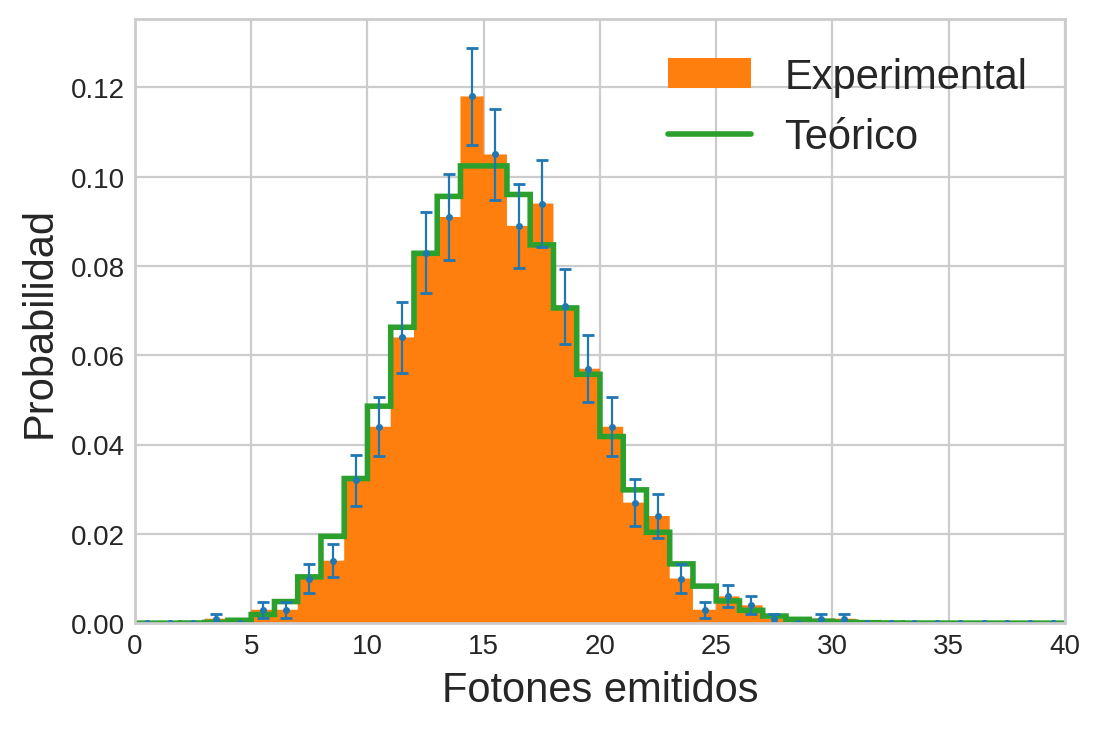

In [7]:
# Genero una rv ahora poissoneana y con ella calculo la probabilidad teórica
rv = poisson(Dt*I)
freq_teo = np.array([rv.pmf(x) for x in range(m)])

# Creo el histograma con los datos generados
freq, bin_edges = np.histogram(experimentos,
                             bins=range(m+1),
                             density=True)
# Grafico los errores
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width/2
barras_error = np.sqrt(freq)/np.sqrt(len(experimentos))

plt.errorbar(bin_centers, freq, yerr=barras_error,
             fmt='.', markersize=3, linewidth=0.8, capsize=2)

plt.stairs(freq, bin_edges, fill=True, label="Experimental")
plt.stairs(freq_teo, bin_edges, linewidth=2,label="Teórico")
plt.xlim([0,40])
plt.xlabel("Fotones emitidos")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

**4)**

Ahora me preguntan la probabilidad de detectar un fotón que fue emitido por la fuente, esto es

$$P(\text{detectar}) = P(\text{absorber} \mid \text{emitir}) P(\text{emitir}),$$

pero esas probabilidades ya las conocemos. La probabilidad de emitir $k$ fotones es la Poisson $P(k \mid \mu)$ donde $\mu$ es el promedio de fotones emitidos, y la probabilidad de absorber $j$ fotones dado que llegaron $k$ al detector es la binomial $B(j \mid k, p)$ donde $p$ es la eficiencia del detector. Como no sabemos cuántos fotones se van a emitir de la fuente, debemos sumar sobre todas las posibilidades, esto es sumar desde $k = 0$ hasta $\infty$. Si lo escribimos explícitamente y desarrollamos queda

$$\begin{aligned}P(\text{detectar}) &= \sum_{k=0, j\geq k}^{\infty} B(j \mid k, p) P(k \mid \mu) \\ &= \sum_{k=0, j\geq k}^{\infty} \frac{k!}{(k-j)!j!} p^j (1-p)^{k-j} \frac{e^{-\mu}\mu^k}{k!} \\ &= \frac{e^{-\mu}p^j \mu^j}{j!} \sum_{k=0, j\geq k}^{\infty} \frac{[(1-p)\mu]^{k-j}}{(k-j)!} \\ &= \frac{e^{-\mu}p^j \mu^j}{j!} e^{(1-p)\mu} \\ &= \frac{e^{-p\mu}(p\mu)^j}{j!}.\end{aligned}$$

Llegamos a que la probabilidad de detectar un fotón emitido por la muestra es Poisson, pero con el valor medio pesado por la eficiencia del detector!.

Entonces, para ver si realmente es así, creo una ```rv``` Poisson con valor medio ```eficiencia * Dt * I``` y lo comparo con los datos generados aleatoriamente.

In [8]:
rv = poisson(eficiencia * Dt*I)

# Para cada experimento de emisión de la fuente, 
# hago un bernoulli con esa cantidad de fotones emitidos.
# Eso simula la probabilidad de detectar los fotones emitidos.
fotones_detectados = np.array(
    [contar_exitos(bernoulli(fot_emit, eficiencia)) for fot_emit in experimentos]
    )

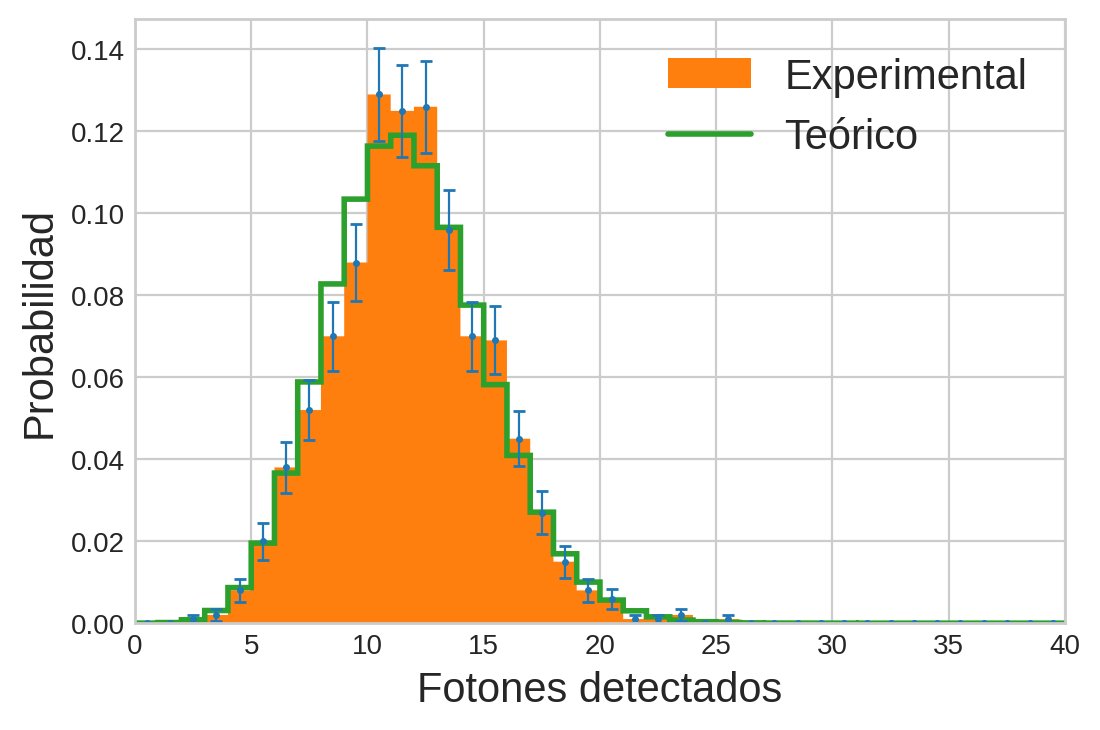

In [9]:
# Creo los histogramas teóricos y generados
freq_teo = np.array([rv.pmf(x) for x in range(m)])
freq, bin_edges = np.histogram(fotones_detectados,
                             bins=range(m+1),
                             density=True)
# Grafico los errores
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width/2
barras_error = np.sqrt(freq)/np.sqrt(len(fotones_detectados))

plt.errorbar(bin_centers, freq, yerr=barras_error,
             fmt='.', markersize=3, linewidth=0.8, capsize=2)
# Grafico
plt.stairs(freq, bin_edges, fill=True, label="Experimental")
plt.stairs(freq_teo, bin_edges, linewidth=2,label="Teórico")
plt.xlim([0,40])
plt.xlabel("Fotones detectados")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

**5)**

Si tenía en cuenta que la probabilidad de detectar un fotón en un intervalo $dt$ es la probabilidad de emitirlo multiplicado por la probabilidad de absorberlo (puedo hacer eso porque son sucesos independientes), entonces podría haber hecho directamente un solo experimento de Bernoulli con esa probabilidad. Además, el proceso es Poisson por lo mismo que expliqué antes.

In [10]:
# Defino los parámetros
Dt= 1
m = 1000
dt = Dt/m
I = 15
eficiencia = 0.75
repeticiones = 1000

# Genero los experimentos
fotones_detectados_todo_junto = bernoulli(m, eficiencia * I*dt, size=(repeticiones, m))
experimentos_todo_junto = contar_exitos(fotones_detectados_todo_junto, axis=1)

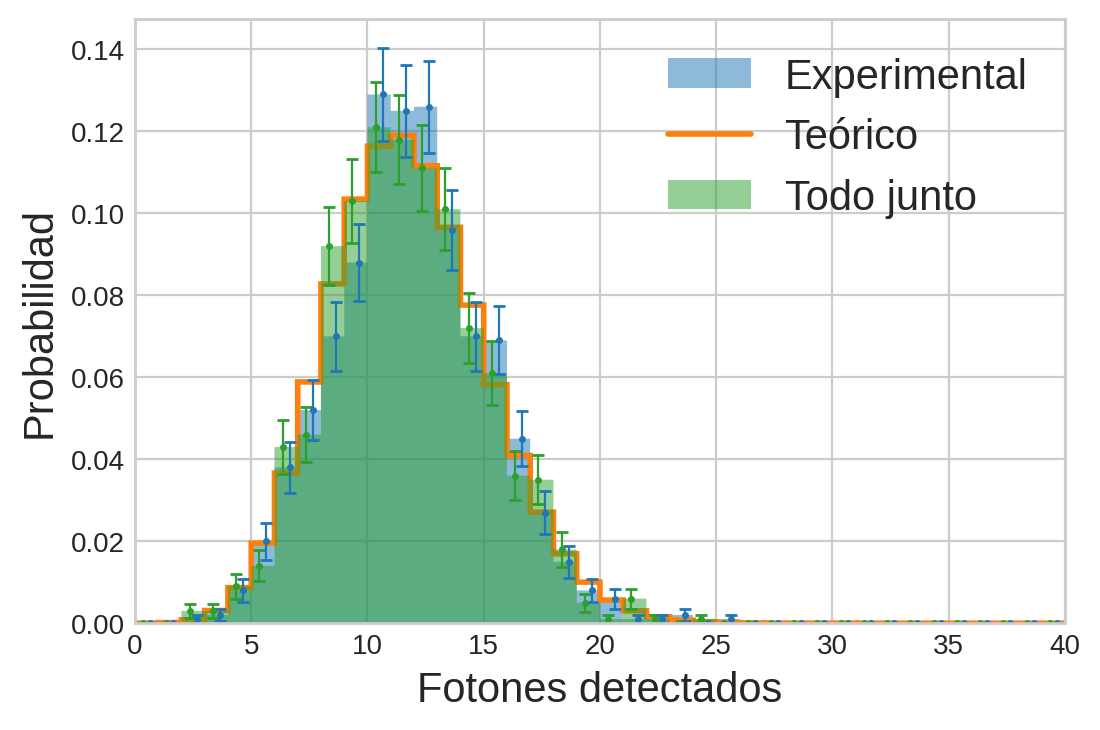

In [11]:
# Creo el histograma del experimento teniendo en cuenta todo junto
freq_todo_junto, bin_edges_todo_junto = np.histogram(experimentos_todo_junto,
                             bins=range(m+1),
                             density=True)
# Grafico errores
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width/2
barras_error_todo_junto = np.sqrt(freq_todo_junto)/np.sqrt(len(experimentos_todo_junto))
barras_error = np.sqrt(freq)/np.sqrt(len(fotones_detectados))
offset = 0.15 * bin_width * np.ones(len(bin_centers))

plt.errorbar(bin_centers - offset, freq_todo_junto, yerr=barras_error_todo_junto,
             color='C2', fmt='.', markersize=3, linewidth=0.8, capsize=2)
plt.errorbar(bin_centers + offset, freq, yerr=barras_error, color='C0',
             fmt='.', markersize=3, linewidth=0.8, capsize=2)

# Grafico reutilizando las frecuencias teóricas que calculé antes, pues son las mismas
plt.stairs(freq, bin_edges, fill=True, label="Experimental", alpha=0.5)
plt.stairs(freq_teo, bin_edges, linewidth=2,label="Teórico")
plt.stairs(freq_todo_junto, bin_edges, fill=True,label="Todo junto", alpha=0.5)
plt.xlim([0,40])
plt.xlabel("Fotones detectados")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

**6)**

Tengo $N$ mediciones en total y $k$ bins en el histograma. La mejor forma de estimar la probabilidad dadas mis mediciones es decir que la probabilidad de que suceda $k$, es decir la probabilidad de que una de las $N$ mediciones caiga en el bin $k$, es $P_k = \frac{N_k}{N}$. Luego, podría decir que cada medición tiene un resultado binario: o está en el bin $k$ o no. Como además mis mediciones son independientes, puedo pensar que el número de mediciones en un dado bin $k$ sigue una distribución binomial

$$P(N_k \mid N, P_k) = {N \choose N_k} P_k^{N_k} (1 - P_k)^{N - N_k},$$

y por lo tanto la dispersión de la cantidad de mediciones en un histograma está dado por la dispersión de la binomial que escribí arriba, que depende de la cantidad de mediciones que tenga en cada bin. Entonces la barra de error que le asignaría a cada bin es $\sqrt{NP_k(1-P_k)} = \sqrt{N \frac{N_k}{N}(1 - \frac{N_k}{N})} \approx \sqrt{N_k}$. Esta forma de estimar la incertidumbre sobre la cantidad de datos en un bin tiene el problema de que le asigna incertidumbre nula a los bins en los que no cayó ninguna medición, ya que en ellos $P_k=0$.

Para no volver a graficar todo le agregué los errores a los histogramas mientras los iba haciendo.

Una observación interesante: si cuento la cantidad de barras de error que incluyen a la probabilidad teórica y divido por la cantidad de barras de error totales la cuenta da alrededor de 0.7, parecido al porcentaje de casos que abarca un intervalo de $2\sigma$ centrado en el valor medio de una distribución gaussiana.